<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка-данных" data-toc-modified-id="Подготовка-данных-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка данных</a></span></li><li><span><a href="#Подбор-гиперпараметров-дерева-решений.-GridSearchCV" data-toc-modified-id="Подбор-гиперпараметров-дерева-решений.-GridSearchCV-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Подбор гиперпараметров дерева решений. GridSearchCV</a></span><ul class="toc-item"><li><span><a href="#Подбор-гиперпараметров-модели" data-toc-modified-id="Подбор-гиперпараметров-модели-2.1"><span class="toc-item-num">2.1&nbsp;&nbsp;</span>Подбор гиперпараметров модели</a></span></li><li><span><a href="#Визуализация-дерева" data-toc-modified-id="Визуализация-дерева-2.2"><span class="toc-item-num">2.2&nbsp;&nbsp;</span>Визуализация дерева</a></span></li></ul></li><li><span><a href="#Интерпретация-модели" data-toc-modified-id="Интерпретация-модели-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Интерпретация модели</a></span><ul class="toc-item"><li><span><a href="#Важность-признаков" data-toc-modified-id="Важность-признаков-3.1"><span class="toc-item-num">3.1&nbsp;&nbsp;</span>Важность признаков</a></span></li><li><span><a href="#Permutation-importance" data-toc-modified-id="Permutation-importance-3.2"><span class="toc-item-num">3.2&nbsp;&nbsp;</span>Permutation importance</a></span></li><li><span><a href="#SHAP" data-toc-modified-id="SHAP-3.3"><span class="toc-item-num">3.3&nbsp;&nbsp;</span>SHAP</a></span></li></ul></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Выводы</a></span></li></ul></div>

In [ ]:
pip install shap

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 540.5/540.5 kB 8.1 MB/s eta 0:00:00


# Постановка задачи и описание данных

Транспортная компания «Маршрут Экспресс» занимается пассажирскими перевозками. Заказчик хочет получить модель для предсказания, понравится ли пассажиру поездка. Так, в будущем компания сможет находить недовольных клиентов и работать над ошибками для улучшения сервиса.

Описание данных:

* `id` — уникальный номер билета;
* `Пол` — пол пассажира (женский, мужской);
* `Возраст` — фактический возраст пассажира, число лет;
* `Путешествует c детьми` — содержит значения 'да' и 'нет';
* `Путешествует по работе` — содержит значения 'да' и 'нет';
* `Тип` — тип вагона (плацкарт, купе, СВ);
* `Расстояние` — расстояние в км между станцией отправления и станцией назначения;
* `Покупка билета онлайн` — билет куплен онлайн (значение 1) или в кассе (значение 0);
* `Питание включено` — пассажир купил услугу предоставления питания (значение 1) или не купил (значение 0);
* `Наличие wifi` — в вагоне есть Wi-Fi (значение 1) или нет (значение 0);
* `Оценка комфортности места` — оценка, выставленная пассажиром по пятибалльной шкале (от 1 до 5);
* `Оценка качества уборки` — оценка, выставленная пассажиром по пятибалльной шкале (от 1 до 5);
* `Оценка качества обслуживания в пути` — оценка, выставленная пассажиром по пятибалльной шкале (от 1 до 5);
* `Удовлетворён предоставленной услугой` — целевой признак, пассажир удовлетворён (значение 1) или нет (значение 0)

## Подготовка данных

In [ ]:
# Загрузим необходимые библиотеки
import pandas as pd  #Основной инструмент аналитика — `pandas`.
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import time

from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
from sklearn.inspection import permutation_importance
import shap


# Загрузим необходимые модели для классификации и метрики качества

from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import plot_tree



from sklearn import metrics
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, make_scorer

pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)

import warnings
warnings.filterwarnings('ignore')

RANDOM_STATE = 12345
TEST_SIZE = 0.25

Прочитаем данные о поездках с помощью `pandas` и поменяем базовые индексы в датафрейме — сделаем индексами идентификаторы клиентов

In [ ]:
# Прочитаем файл с данными в переменную df и изучим их
try:
    from google.colab import drive
    drive.mount('/content/drive')
    df = pd.read_csv('/content/drive/My Drive/train_satisfaction.csv')
    df = df.set_index('id')
except:
    df = pd.read_csv('train_satisfaction.csv')
    df = df.set_index('id')


Mounted at /content/drive


In [ ]:
# первые 5 строк датасета
df.head()

,Пол,Возраст,Путешествует с детьми,Путешествует по работе,Тип,Расстояние,Покупка билета онлайн,Питание включено,Наличие wifi,Оценка комфортности места,Оценка качества уборки,Оценка качества обслуживания в пути,Удовлетворён предоставленной услугой
id,,,,,,,,,,,,,
23224169,муж,28,нет,да,купе,2415,1,0,1,4,4,3,1
34061233,муж,51,да,нет,плацкарт,973,1,0,1,4,4,5,1
72412002,жен,36,нет,да,плацкарт,1416,1,1,0,2,2,3,1
39685985,жен,58,да,да,св,703,1,0,1,3,3,2,1
37903434,жен,46,нет,нет,плацкарт,162,1,1,1,1,2,3,1


In [ ]:
# посчитайте, сколько раз встречается каждый класс, методом value_counts()
df['Удовлетворён предоставленной услугой'].value_counts()

Удовлетворён предоставленной услугой
1    6061
0     939
Name: count, dtype: int64

Налицо дисбаланс классов. Нужно это учесть при выборе подходящей метрики качества.

Перед нами задача бинарной классификации и дисбаланс в классах — это работа для метрики `ROC-AUC`. Она отлично подходит для бинарной классификации с несбалансированной выборкой.

Т.к. в данных есть дисбаланс классов, нужно обязательно выполнить стратификацию по целевому признаку.


Поделите данные на тренировочную и тестовую выборки в отношении 3:1, сделайте стратификацию по целевому признаку. Затем подготовьте список строковых категорий для кодирования.

In [ ]:
# делим данные на входные и целевые
X = df.drop(['Удовлетворён предоставленной услугой'], axis=1)
y = df['Удовлетворён предоставленной услугой']

In [ ]:
# Разделите данные на тренировочную и тестовую выборки:
# - используйте константы с размером тестовой выборки и random_state;
# - сделайте стратификацию по целевому признаку.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_SIZE,
                                                    random_state=RANDOM_STATE,stratify = y)


In [ ]:
# создайте списки с количественными и категориальными признаками
cat_col_names = X_train.select_dtypes(include='object').columns.tolist()
num_col_names = X_train.select_dtypes(include='number').columns.tolist()

# выберите класс OrdinalEncoder() для кодирования

ord = OrdinalEncoder()

# обучите и преобразуйте категориальные признаки из тренировочной и тестовой выборок
# для тренировочной выборки выполните действия одной командой
X_train_ord = ord.fit_transform(X_train[cat_col_names])
X_test_ord = ord.transform(X_test[cat_col_names])

# сохраняем в переменной encoder_col_names список названий новых столбцов
encoder_col_names = cat_col_names


# создаём датафрейм из закодированных данных
# передаём названия столбцов из переменной encoder_col_names
X_train_ord = pd.DataFrame(X_train_ord, columns=encoder_col_names)
X_test_ord = pd.DataFrame(X_test_ord, columns=encoder_col_names)

# обнуляем индексы строк перед объединением количественных и категориальных
# признаков в датафрейм
X_train = X_train.reset_index()
X_test = X_test.reset_index()

# объедините количественные и категориальные признаки для тренировочного
# и тестового датасетов
X_train = pd.concat([X_train_ord, X_train[num_col_names]], axis=1)
X_test = pd.concat([X_test_ord, X_test[num_col_names]], axis=1)

## Подбор гиперпараметров дерева решений. GridSearchCV

Подбирать гиперпараметры с помощью циклов не самый эффективный способ. Во-первых, это долго: понадобится перебрать все комбинации настроек. Во-вторых, сложно: придётся написать много кода, который, к тому же, трудно читать.

Инструмент для автоматизированного поиска гиперпараметров — `GridSearchCV` в `sklearn` - создаёт отдельную модель для каждой комбинации настроек, обучает её и считает метрику при кросс-валидации. Пользоваться таким инструментом удобно: он быстрее циклов и требует меньше кода.

Класс `GridSearchCV` выглядит следующим образом:

`GridSearchCV(
  estimator,
  param_grid,
  scoring=None,
  n_jobs=None,
  cv=None
) `

Параметры класса:
* `estimator` (обязательный) — инициализированная модель.
* `param_grid` (обязательный) — словарь со значениями гиперпараметров. Ключи — названия гиперпараметров, а по ключам хранятся списки значений гиперпараметров.
* `scoring` — метрика, которая будет считаться на обученных моделях.
* `n_jobs` — количество вычислительных мощностей. Чтобы считалось быстрее, указывают -1.
* `cv` — тип кросс-валидации.

Чтобы запустить поиск лучших значений гиперпараметров, нужно вызвать метод `fit()`:

инициализируем класс для поиска гиперпараметров

`gs = GridSearchCV(
    model,
    parameters
)`

запускаем поиск лучших гиперпараметров

`gs.fit(X_train, y_train)`

Когда поиск выполнится, код выведет лучшие значения гиперпараметров с помощью атрибута класса `GridSearchCV` — `gs.best_params_`

Что ещё вам может пригодиться:
* `best_estimator_ ` — лучшая обученная модель;
* `best_score_` — лучшая метрика при кросс-валидации;
* `cv_results_` — общие результаты поиска гиперпараметров.

### Подбор гиперпараметров модели

Подберите лучшие значения гиперпараметров на примере датасета про пассажирские перевозки. Вы уже делали подобное в цикле, используйте те же значения гиперпараметров.

Создайте словарь со значениями гиперпараметров:
* `min_samples_split` в диапазоне от 2 до 6 (не включительно);
* `min_samples_leaf` в диапазоне от 1 до 6 (не включительно);
* `max_depth` в диапазоне от 2 до 6 (не включительно).

Инициализируйте класс `GridSearchCV`. В качестве значения кросс-валидации укажите 5, также передайте метрику `roc-auc` и `n_jobs=-1`.

Запустите поиск гиперпараметров.

In [ ]:
# запускаем таймер
start = time.time()


# инициализируем модель дерева решений
model = DecisionTreeClassifier(random_state=RANDOM_STATE, class_weight = 'balanced')

# Создайте словарь с гиперпараметрами:
# - min_samples_split в диапазоне от 2 до 6 (не включительно);
# - min_samples_leaf в диапазоне от 1 до 6 (не включительно);
# - max_depth в диапазоне от 2 до 6 (не включительно).
parameters = {
    'min_samples_split': range(2, 6),
    'min_samples_leaf': range(1, 6),
    'max_depth': range(2, 6)
}

# Инициализируйте класс для автоматизированного поиска:
# значение кросс-валидации 5, метрика roc-auc и n_jobs=-1.
gs = GridSearchCV(
    model,
    parameters,
    n_jobs=-1,
    cv=5,
    scoring = 'roc_auc'
)


# запустите поиск гиперпараметров
gs.fit(X_train, y_train)

# считаем, сколько секунд прошло с начала запуска
gs_search_time = time.time() - start
print(f'Search time:{gs_search_time}')

# выведите лучшие гиперпараметры
print('Гиперпараметры', gs.best_params_)
# выведите лучшую метрику качества
print('ROC-AUC', gs.best_score_)

Search time:8.44614553451538
Гиперпараметры {'max_depth': 4, 'min_samples_leaf': 1, 'min_samples_split': 2}
ROC-AUC 0.8947455152331315


### Визуализация дерева

Чтобы визуализировать построенное дерево, понадобится функция `plot_tree` из модуля `sklearn.tree`.

Функции нужно передать обученную модель с помощью параметра `decision_tree`. В конце строки указывают точку с запятой, чтобы вместе с графиком не выводился лишний текст. С помощью параметра `feature_names` отражаем наименование признаков в правилах.  Схему можно сделать цветной, указав аргумент `filled=True`

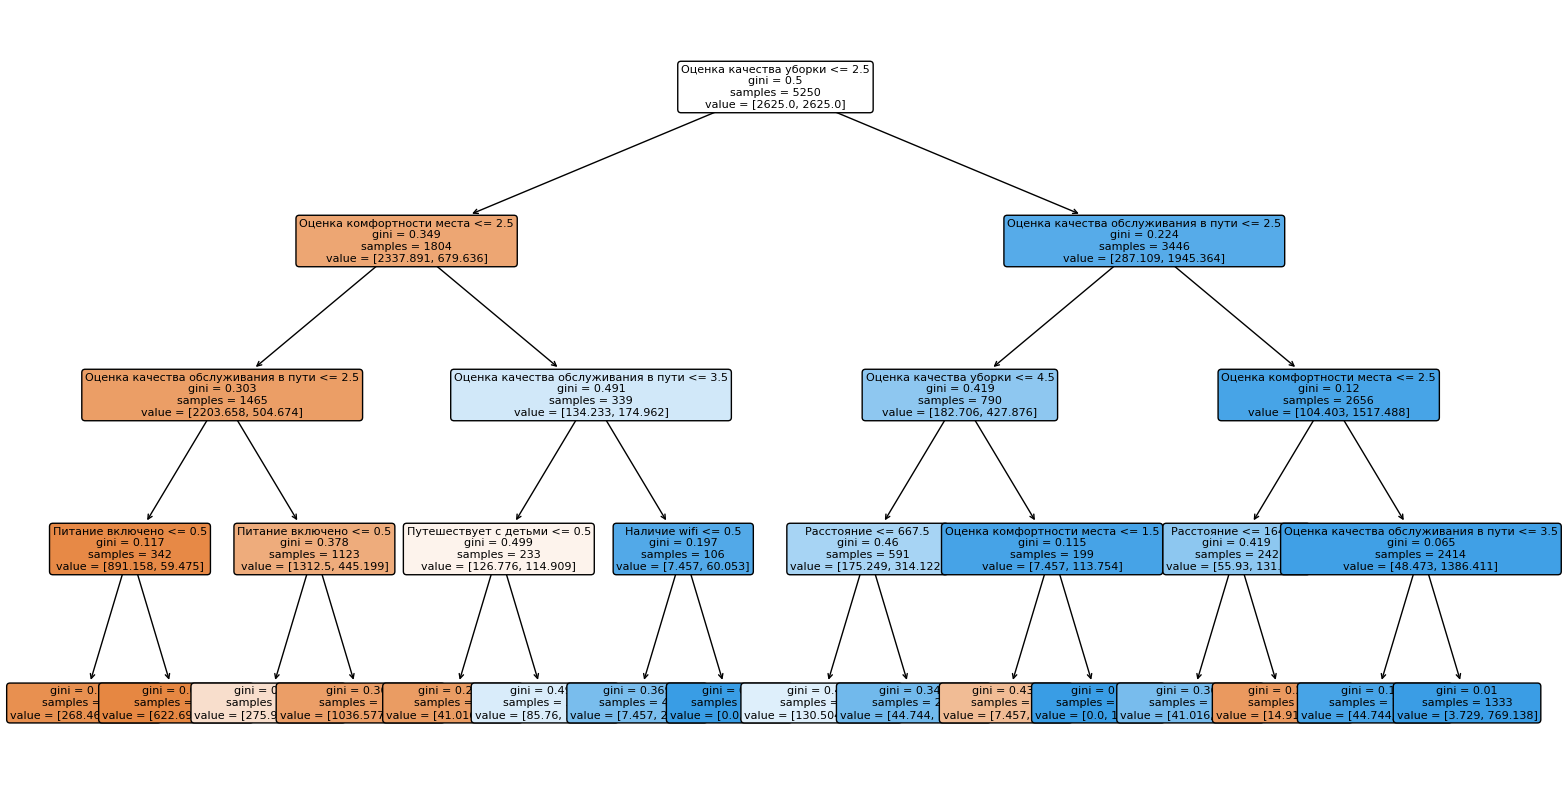

In [ ]:
# добавляем размер графика
plt.figure(figsize=(16, 8))

# визуализируйте модель дерева решений, отобразите названия признаков
# и раскрасьте узлы

plot_tree(decision_tree=gs.best_estimator_, feature_names=X_train.columns, filled=True, rounded = True, fontsize=8);
plt.tight_layout()
plt.show()

## Интерпретация модели

### Важность признаков

Цель отбора признаков — найти те, которые вносят наибольший вклад в корректное предсказание. Это свойство называют важностью признаков (англ. `feature importance`).

Интерпретация модели всегда подразумевает анализ работы алгоритмов: необходимо понять, какие признаки они оценили как наиболее важные.
Для этого полезен показатель `feature importance`.

Стратегии на основе дерева естественным образом ранжируются по тому, насколько хорошо они улучшают чистоту модели в плане данных. Таким образом, “обрезая” деревья ниже определенного коэффициента, мы можем подобрать наиболее важные признаки.

In [ ]:
gs.best_estimator_.feature_importances_

array([0.        , 0.00813082, 0.        , 0.        , 0.        ,
       0.0174838 , 0.        , 0.0293111 , 0.00142906, 0.08067901,
       0.78069044, 0.08227576])

In [ ]:
# Важность признаков оценим с помощью feature_importances_
feature_imp = pd.DataFrame(
     {'Признак' :X_train.columns,
        'Важность':gs.best_estimator_.feature_importances_
     }).sort_values(by ='Важность',  ascending = False)
feature_imp

,Признак,Важность
10,Оценка качества уборки,0.780690
11,Оценка качества обслуживания в пути,0.082276
9,Оценка комфортности места,0.080679
7,Питание включено,0.029311
5,Расстояние,0.017484
1,Путешествует с детьми,0.008131
8,Наличие wifi,0.001429
0,Пол,0.000000
2,Путешествует по работе,0.000000
3,Тип,0.000000


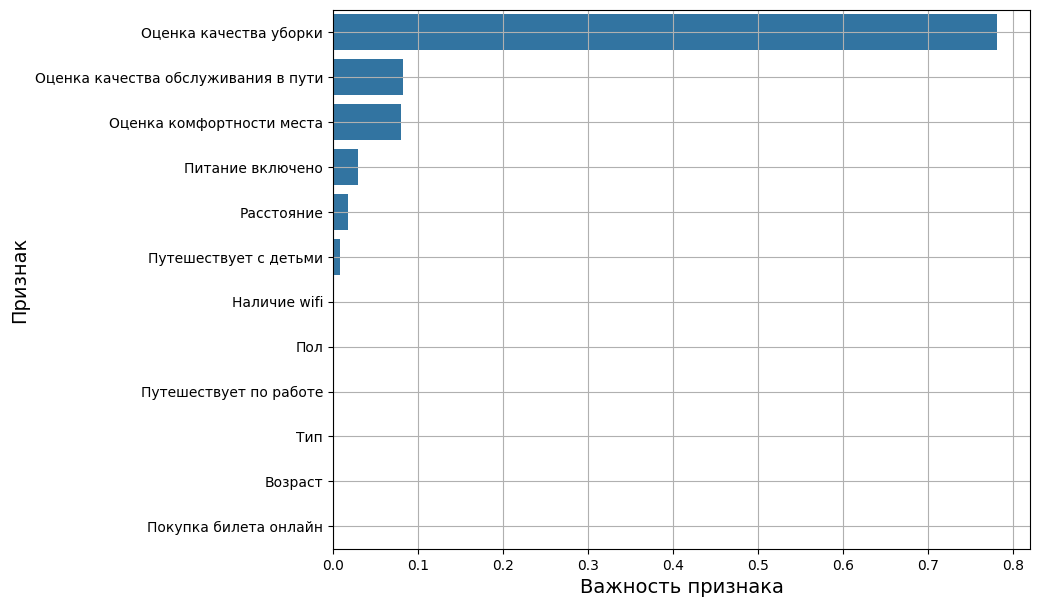

In [ ]:
# Визуализируем важность признаков
# добавляем размер графика
plt.figure(figsize=(9, 7))

sns.barplot(x=feature_imp['Важность'],y=feature_imp['Признак'])

plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

Видим, что наиболее важным признаком для прогнозирования удовлетворенности пассажира является признак "Оценка качества уборки". Менее важными я вляются признаки "Оценка качества обслуживания в пути" и "Оценка комфортности места".

### Permutation importance

Самый простой показатель для оценки важности признаков в моделях без встроенных весов называют `permutation importance`. На русский язык фразу можно примерно перевести как «перестановочная важность» или «важность после перестановки».

`Permutation importance` — это метод проверки модели, который измеряет вклад каждого признака в статистические характеристики подобранной модели в заданном наборе табличных данных. Этот метод особенно полезен для нелинейных или непрозрачных оценок и включает в себя случайное перемешивание значений одного признака и наблюдение за результирующим ухудшением оценки модели

Оценить важность признаков после перестановки можно любой подходящей метрикой. Алгоритм `permutation importance` измерит качество модели по умолчанию, а затем:
* поочерёдно перемешает значения в каждом признаке;
* проверит качество модели после изменений в каждом признаке;
* сравнит, насколько модель с изменённым признаком показала себя хуже исходной;
* проранжирует все признаки по важности.

Оценка `permutation importance` реализована в модуле `sklearn.inspection`.

Чтобы проверить важность признаков после перестановки, нужно передать функции обученную модель, тестовые данные и метрику, которой вы хотите оценить качество модели.

In [ ]:
permutation =permutation_importance(gs.best_estimator_, X_test, y_test, scoring='roc_auc')

In [ ]:
permutation

{'importances_mean': array([ 0.00000000e+00, -1.60522435e-03,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  5.78330173e-04,  0.00000000e+00,  1.02231585e-02,
         1.29204410e-05,  1.07547504e-01,  1.55835405e-01,  3.98087213e-02]),
 'importances_std': array([0.        , 0.0011328 , 0.        , 0.        , 0.        ,
        0.00153503, 0.        , 0.00195475, 0.00182052, 0.00793388,
        0.01313934, 0.0067519 ]),
 'importances': array([[ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [-1.53360017e-03, -3.03349484e-03, -7.66800084e-04,
         -2.67537392e-03, -1.68527491e-05],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
          0.00000000e+00,  0.00000000e+00],
        [ 1.92963977e-03, 

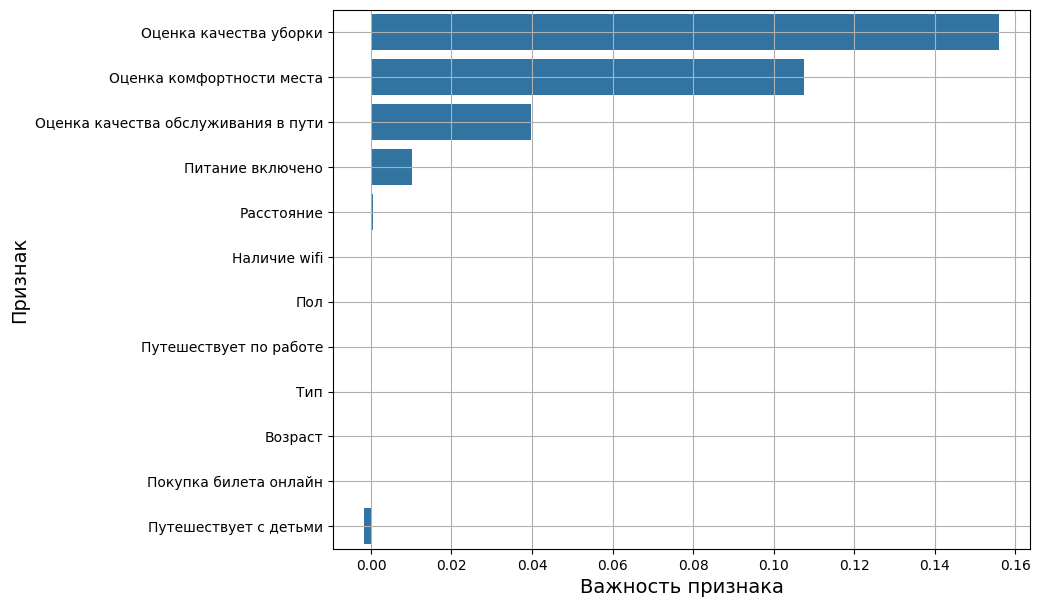

In [ ]:
# Сформируем датафрейм на основе важностей презнаков перестановки
feature_importance = pd.DataFrame({
    'Признак':X_test.columns,
    'Важность':permutation['importances_mean']

}).sort_values('Важность', ascending=False)

# Визуализируем результат в виде столбиковой диаграммы

plt.figure(figsize=(9, 7))

sns.barplot(y=feature_importance['Признак'],x=feature_importance['Важность'])

plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()

In [ ]:
feature_importance

,Признак,Важность
10,Оценка качества уборки,0.155835
9,Оценка комфортности места,0.107548
11,Оценка качества обслуживания в пути,0.039809
7,Питание включено,0.010223
5,Расстояние,0.000578
8,Наличие wifi,0.000013
0,Пол,0.000000
2,Путешествует по работе,0.000000
3,Тип,0.000000
4,Возраст,0.000000


Перемешивание значений выявило других фаворитов, хотя и этот критерий значимости лучше всего прошёл признак "Оценка качества уборки".  На втором месте по важности оказался признак "Оценка комфортности места" вместо "Оценка качества обслуживания в пути". Причем разница в важности этих признаков более заметная.

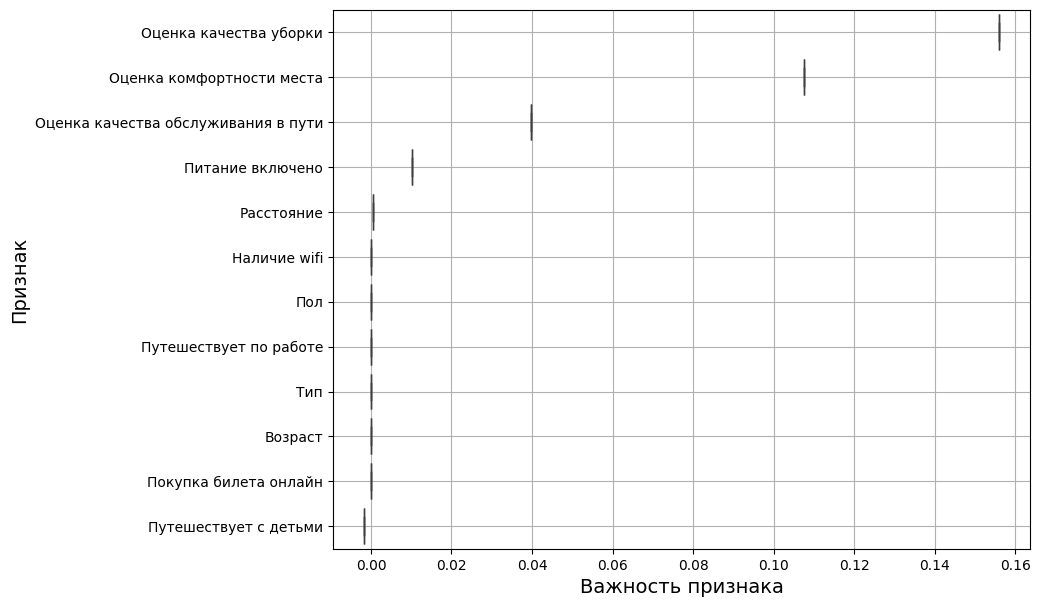

In [ ]:
# Визуализируем важность признаков после перестановки в виде диаграмм размаха

# добавляем размер графика

plt.figure(figsize=(9, 7))

sns.boxplot(x=feature_importance['Важность'],y=feature_importance['Признак'],whis=10)

plt.xlabel("Важность признака", fontsize = 14)
plt.ylabel("Признак", fontsize = 14)
plt.grid()
plt.show()


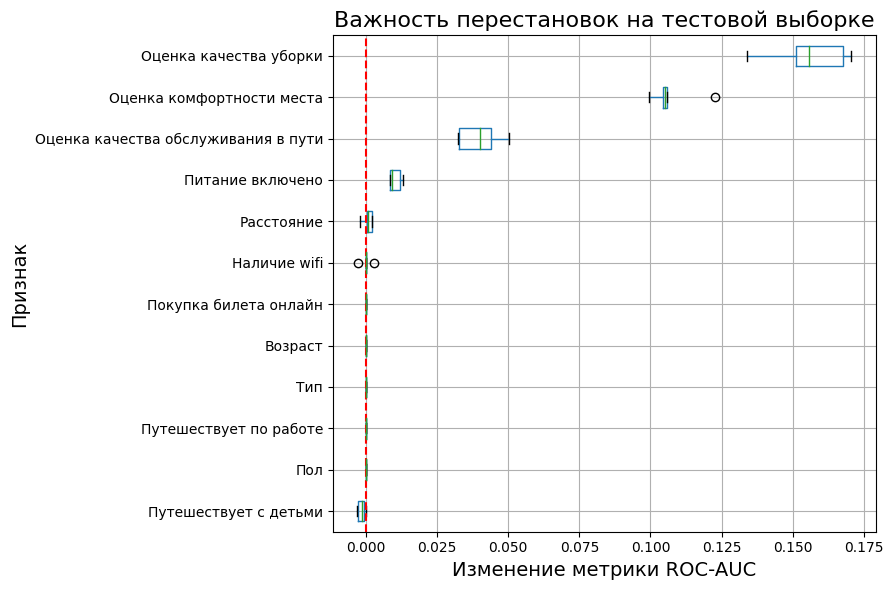

In [ ]:
sorted_importances = permutation.importances_mean.argsort()
importances = pd.DataFrame(
    permutation.importances[sorted_importances].T,
    columns=X_train.columns[sorted_importances],
)

plt.figure(figsize=(9, 6))

ax = importances.boxplot(vert=False, whis=5)
ax.axvline(x=0, color="red", linestyle="--")

plt.xlabel('Изменение метрики ROC-AUC', fontsize = 14)
plt.ylabel('Признак', fontsize = 14)
plt.title('Важность перестановок на тестовой выборке', fontsize = 16)
plt.tight_layout()
plt.show()


Видим, что наибольшие изменения в метрике `ROC-AUC` наблюдаются при перестановке значений признаков "Оценка качества уборки", "Оценка комфортности места" и "Оценка качества обслуживания в пути".

`Permutation importance` — наглядный метод, но он не позволяет оценить, как признак влияет на каждое отдельное предсказание. Для этого разработали другие подходы

### SHAP

Однозначную оценку вклада признака в каждый прогноз показывают значения Шепли, их оценивают методом `SHAP` (`SHapley Additive exPlanations`). Он вычисляет, как отдельный признак помог присвоить модели итоговое значение целевого.

Значения Шепли — это понятие из теории игр, которое используют для оценки распределения выигрыша между партнёрами по игре. К примеру, очевидно, что у каждого игрока баскетбольной команды разный вклад во время игры. Если вы захотите наградить каждого после победы в матче в зависимости от его или её заслуг, вам нужно формализовать распределение выигрыша каждого с математической точностью.

**Диаграмма `shap.plots.bar` отражает результаты усреднения `SHAP`-значений**

Столбчатая диаграмма `shap.plots.bar` отражает общий вклад признаков в прогнозы модели. Она показывает средние SHAP-значения признака по всем наблюдениям. Для расчёта средних берут значения Шепли по модулю, чтобы положительные и отрицательные значения не сводили друг друга к нулю.

Для того, чтобы определить, какие признаки, в целом, являются наиболее важными для прогнозов, выдаваемых моделью, можно использовать столбчатую диаграмму (`shap.plots.bar`), отражающую результаты усреднения `SHAP`-значений по всем наблюдениям. Расчёт среднего на основании абсолютных значений показателей позволяет добиться того, чтобы положительные и отрицательные значения не уничтожали бы друг друга.



In [ ]:
# Вычисляем значения Шепли
explainer =shap.TreeExplainer(gs.best_estimator_, X_test)

shap_values =explainer.shap_values(X_test)

shap_val =explainer(X_test)

In [ ]:
shap_val

.values =
array([[[ 0.        ,  0.        ],
        [-0.00347412,  0.00347412],
        [ 0.        ,  0.        ],
        ...,
        [-0.18726003,  0.18726003],
        [-0.0815895 ,  0.08158949],
        [-0.07189697,  0.07189696]],

       [[ 0.        ,  0.        ],
        [-0.03474122,  0.03474122],
        [ 0.        ,  0.        ],
        ...,
        [-0.15853544,  0.15853545],
        [ 0.12421969, -0.12421966],
        [ 0.18009263, -0.18009261]],

       [[ 0.        ,  0.        ],
        [-0.01010654,  0.01010654],
        [ 0.        ,  0.        ],
        ...,
        [ 0.25927564, -0.25927566],
        [ 0.20595988, -0.20595988],
        [ 0.14204773, -0.14204776]],

       ...,

       [[ 0.        ,  0.        ],
        [-0.00568493,  0.00568493],
        [ 0.        ,  0.        ],
        ...,
        [-0.08477189,  0.08477189],
        [-0.06304857,  0.06304857],
        [ 0.2267024 , -0.22670239]],

       [[ 0.        ,  0.        ],
        [-0.00568

In [ ]:
shap_values

array([[[ 0.        ,  0.        ],
        [-0.00347412,  0.00347412],
        [ 0.        ,  0.        ],
        ...,
        [-0.18726003,  0.18726003],
        [-0.0815895 ,  0.08158949],
        [-0.07189697,  0.07189696]],

       [[ 0.        ,  0.        ],
        [-0.03474122,  0.03474122],
        [ 0.        ,  0.        ],
        ...,
        [-0.15853544,  0.15853545],
        [ 0.12421969, -0.12421966],
        [ 0.18009263, -0.18009261]],

       [[ 0.        ,  0.        ],
        [-0.01010654,  0.01010654],
        [ 0.        ,  0.        ],
        ...,
        [ 0.25927564, -0.25927566],
        [ 0.20595988, -0.20595988],
        [ 0.14204773, -0.14204776]],

       ...,

       [[ 0.        ,  0.        ],
        [-0.00568493,  0.00568493],
        [ 0.        ,  0.        ],
        ...,
        [-0.08477189,  0.08477189],
        [-0.06304857,  0.06304857],
        [ 0.2267024 , -0.22670239]],

       [[ 0.        ,  0.        ],
        [-0.00568493,  0.00

Объект `shap_values` представляет собой список с двумя массивами. Первый массив — это значения SHAP для отрицательного результата (класс 0), а второй массив — список значений SHAP для положительного результата (класс 1). Для положительных результатов мы извлекаем значения SHAP (вытаскивая `shap_values[1]`).

Просматривать необработанные массивы затруднительно, поэтому в пакете `shap` есть удобный способ визуализировать результаты.

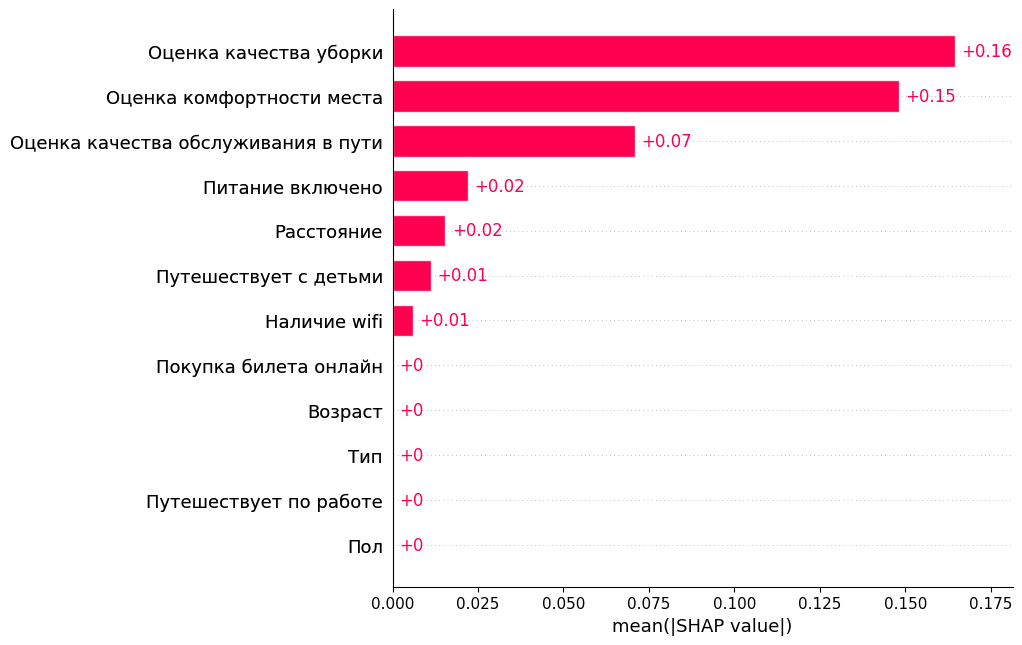

In [ ]:
# Построим график общей значимости признаков :
shap.plots.bar(shap_val[:,:,1],max_display=12)


Каждому признаку соответствует свой столбец диаграммы, его размер отражает среднее SHAP‑значение по признаку. Признаки на графике расположены в порядке убывания их вклада: если убрать те, что наверху, качество модели просядет сильнее всего.

У нас самый большой вес у признака "Оценка качества уборки", он сильнее всего влияет на прогнозы модели неудовлетворенности пассажира поездкой.

Вторым по значимости является признак — "Оценка комфортности места".



**График shap.plots.beeswarm**

Диаграмма `shap.plots.beeswarm` — это один из вариантов визуализации вклада признаков в каждое предсказание модели. На графике точками отображены все наблюдения из выборки.
На оси $X$ отложены значения Шепли, на оси $Y$ — признаки модели, расположенные сверху вниз в порядке убывания средних SHAP‑значений.

`Bee Swarm Plot` показывает распределение вкладов каждого признака для каждого наблюдения, выделяя ключевые признаки и их влияние.

Диаграмма `shap.plots.beeswarm` — это полезный инструмент, позволяющий визуализировать все `SHAP`-значения для каждого признака. По оси x этой диаграммы `SHAP`-значения сгруппированы по признакам. А цвет точек указывает на соответствующее значение признака. Обычно точки, цвет которых ближе к красному, указывают на более высокие значения признаков.

Диаграмма `shap.plots.beeswarm` может помочь в выявлении важных взаимоотношений между признаками и прогнозами модели. На нашей диаграмме признаки упорядочены по их средним `SHAP`-значениям.

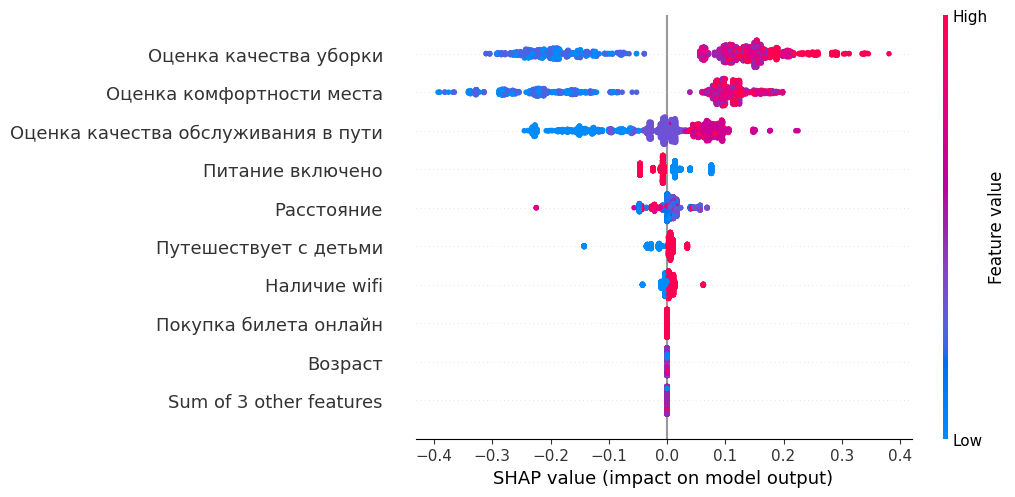

In [ ]:
# Посмотрим, как признаки влияют на каждое предсказание модели:
shap.plots.beeswarm(shap_val[:,:,1])

Вот как читать этот график:
* Негативные значения Шепли слева от центральной вертикальной линии означают, что признак склоняет модель отнести объекты к классу 0, а положительные справа — к классу 1.
* Чем толще линия по вертикали, тем больше наблюдений сгруппированы вместе: у них близкие значения Шепли. Это значит, что модель уверенно присваивает SHAP-значения, с учётом закономерностей в данных.
* Цвет точки отражает значения каждого признака объекта: чем краснее объект, тем больше признак, указанный на оси Y.



Видим, что высокое значение признака "Оценка качества уборки" увеличивает вероятность принадлежности пассажира к классу 1 (повышает удовлетворенность поездкой). Низкое значение признака "Оценка качества уборки", наоборот, увеличивает вероятность принадлежности пассажира к классу 0 (повышает вероятность неудовлетвлренности поездкой)

**График shap.plots.waterfall**

Диаграмма `shap.plots.waterfall` визуализирует индивидуальные SHAP-значения каждого наблюдения в датасете.

Вот как будет выглядеть график для пятнадцатого объекта:

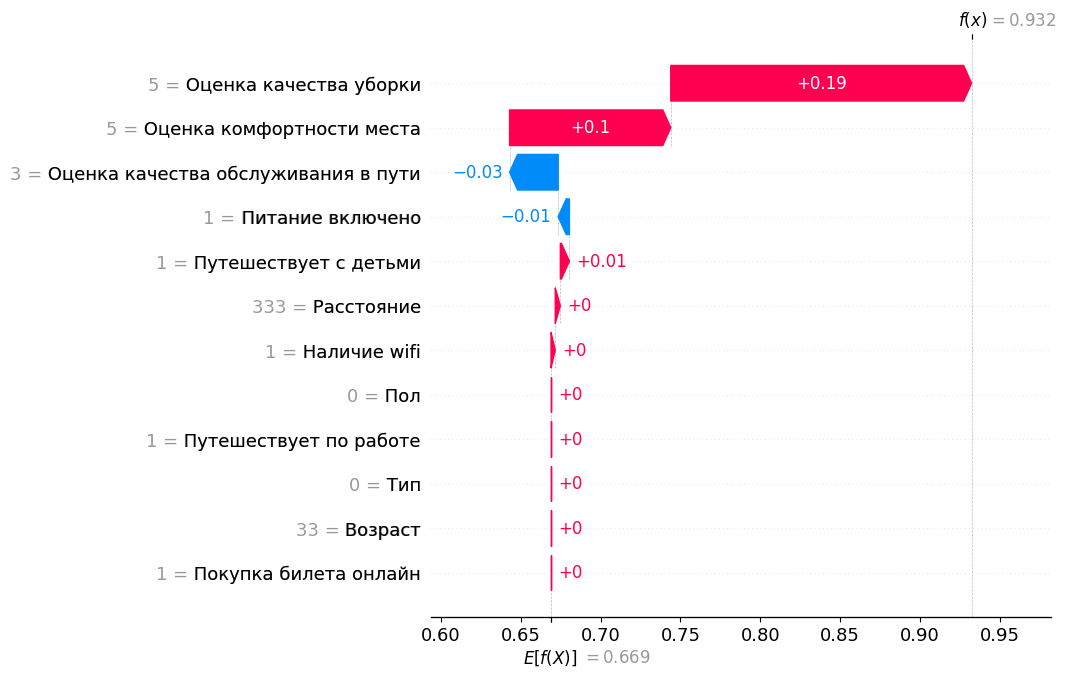

In [ ]:
shap.plots.waterfall(shap_val[:,:,1][15],max_display=12)

Посмотрим, сколько раз модель ошиблась, когда предсказала удовлетворенность поездкой (предсказала класс 1):

Рассмотрим отдельные примеры неверно классифицированных объектов. Для этого отфильтруем такие наблюдения по двум критериям:
* Истинное значение целевого признака — 0.
* Вероятность принадлежность к классу 1 была оценена выше чем 0.8

In [ ]:
X_test_df = X_test.copy()
X_test_df['y_test'] = y_test.tolist()
X_test_df['predict_proba_1'] = gs.best_estimator_.predict_proba(X_test)[:,1]

X_test_df[(X_test_df['y_test']==0)&(X_test_df['predict_proba_1']>0.8)]

,Пол,Путешествует с детьми,Путешествует по работе,Тип,Возраст,Расстояние,Покупка билета онлайн,Питание включено,Наличие wifi,Оценка комфортности места,Оценка качества уборки,Оценка качества обслуживания в пути,y_test,predict_proba_1
117,1.0,1.0,1.0,1.0,53,2491,1,1,1,5,5,3,0,0.932412
120,1.0,1.0,1.0,0.0,59,851,1,1,0,3,3,3,0,0.932412
136,0.0,0.0,1.0,1.0,55,821,1,0,1,2,5,2,0,1.000000
188,0.0,1.0,0.0,0.0,28,2379,1,1,1,3,3,3,0,0.932412
583,0.0,1.0,1.0,1.0,20,509,1,1,0,5,5,3,0,0.932412
616,0.0,1.0,0.0,1.0,45,706,1,1,1,4,3,3,0,0.932412
712,0.0,1.0,0.0,1.0,36,1286,1,1,1,3,3,4,0,0.995176
966,0.0,1.0,1.0,1.0,67,1156,1,1,1,4,2,4,0,1.000000
1077,0.0,1.0,0.0,2.0,45,587,1,1,1,3,3,3,0,0.932412
1317,0.0,1.0,1.0,1.0,19,570,1,1,0,4,4,4,0,0.995176


Таких объектов у нас 13. Оценим вклад некоторых признаков для этих наблюдений

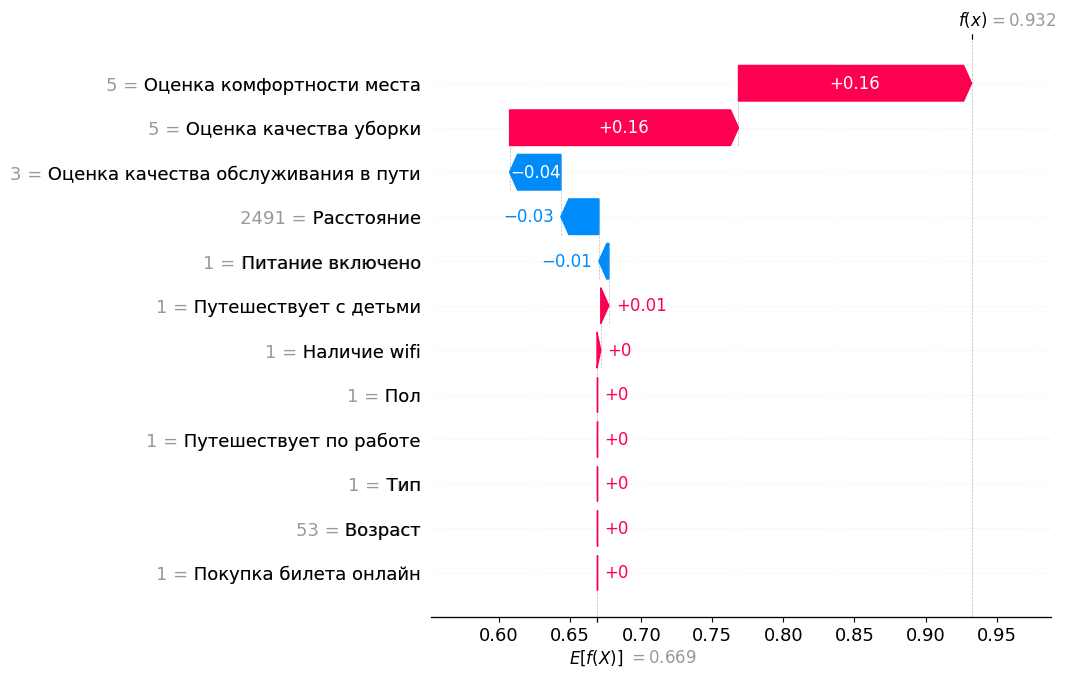

In [ ]:
# Визуализируем индивидуальные SHAP-значения для 117 наблюдения в датасете

shap.plots.waterfall(shap_val[:,:,1][117],max_display=12)

Модель отнесла этот объект к классу 1 (удовлетворен поездкой), потому что оценки качества уборки и комфортности места высокие, несмотря на то, что оценка качества обслуживания в пути была средняя. Это склонило модель к неверному решению.

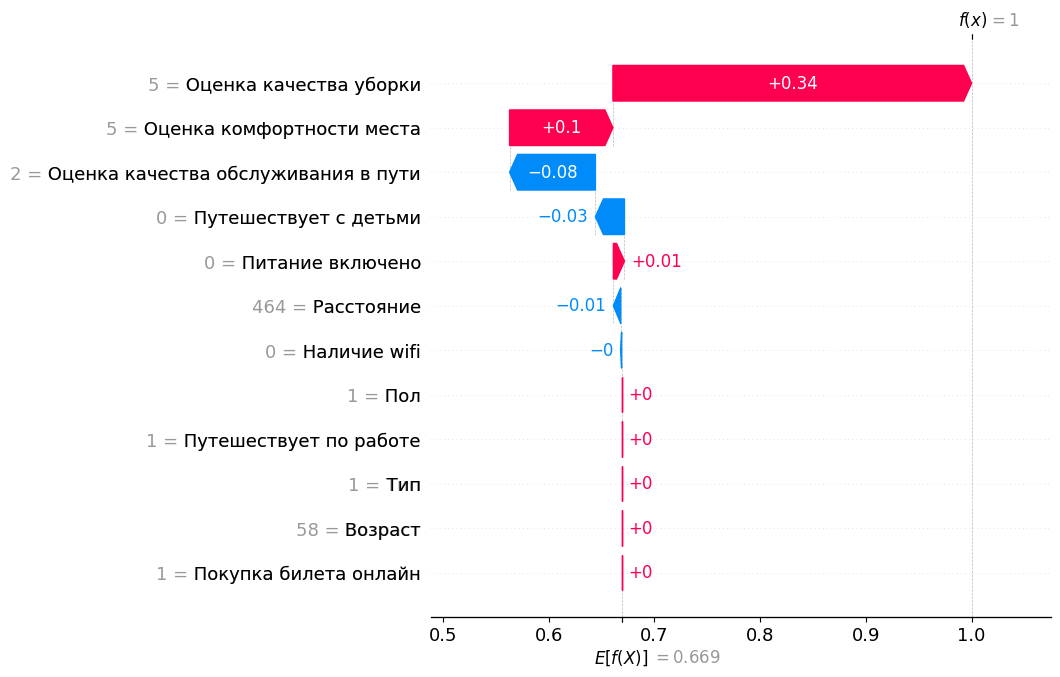

In [ ]:
# Визуализируем индивидуальные SHAP-значения для 1397 наблюдения в датасете

shap.plots.waterfall(shap_val[:,:,1][1397],max_display=12)

Здесь причина неверного решения модели аналогична предыдущему пассажиру. Высокие оценки качества уборки и комфортности места склонили модель к удовлетворенности пассажира.

Посмотрим, сколько раз модель ошиблась, когда предсказала неудовлетворенность поездкой.

In [ ]:
X_test_df[(X_test_df['y_test']==1)&(X_test_df['predict_proba_1']<0.2)]

,Пол,Путешествует с детьми,Путешествует по работе,Тип,Возраст,Расстояние,Покупка билета онлайн,Питание включено,Наличие wifi,Оценка комфортности места,Оценка качества уборки,Оценка качества обслуживания в пути,y_test,predict_proba_1
14,0.0,0.0,0.0,0.0,54,614,1,1,0,3,1,2,1,0.174355
27,0.0,1.0,1.0,1.0,65,726,1,1,0,1,1,4,1,0.188504
44,0.0,1.0,1.0,1.0,54,295,0,1,0,2,2,4,1,0.188504
61,1.0,1.0,1.0,0.0,62,659,1,1,1,2,2,3,1,0.188504
66,1.0,0.0,0.0,2.0,61,1255,1,0,0,2,2,2,1,0.105783
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1713,0.0,1.0,1.0,1.0,25,2644,0,1,0,2,2,3,1,0.188504
1714,0.0,0.0,1.0,1.0,43,345,1,1,1,2,2,4,1,0.188504
1715,0.0,1.0,0.0,1.0,27,822,1,1,1,2,2,3,1,0.188504
1723,1.0,1.0,0.0,1.0,23,1359,1,1,1,1,1,3,1,0.188504


Таких объектов 192.

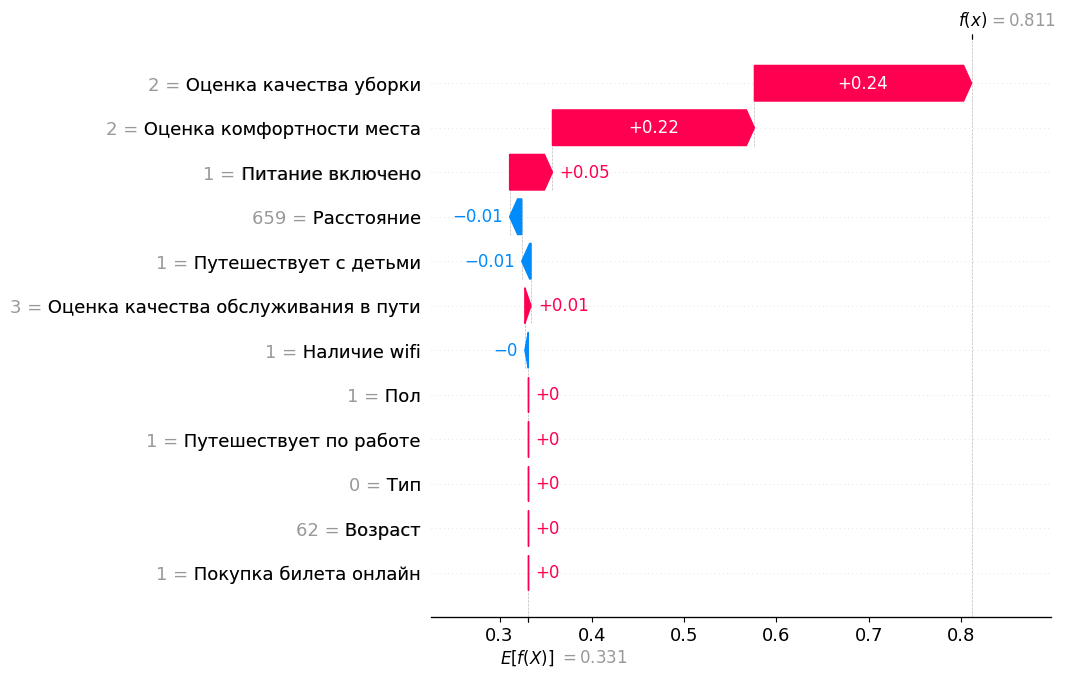

In [ ]:
# Визуализируем индивидуальные SHAP-значения для 61 наблюдения в датасете
shap.plots.waterfall(shap_val[:,:,0][61],max_display=12)

Модель предсказала, что клиент 61 будет неудовлетворен поездкой из-за низких оценок качества уборки и комфортности места.

**Диаграмма `shap.plots.scatter` и исследование взаимоотношений значений**

Для того чтобы лучше понять взаимоотношения между отдельными значениями признаков и их `SHAP`-значениями, можно создать диаграмму зависимости (`shap.plots.scatter`). Это — диаграмма, которая раскрывает взаимоотношения между `SHAP`-значениями и значениями отдельных признаков.

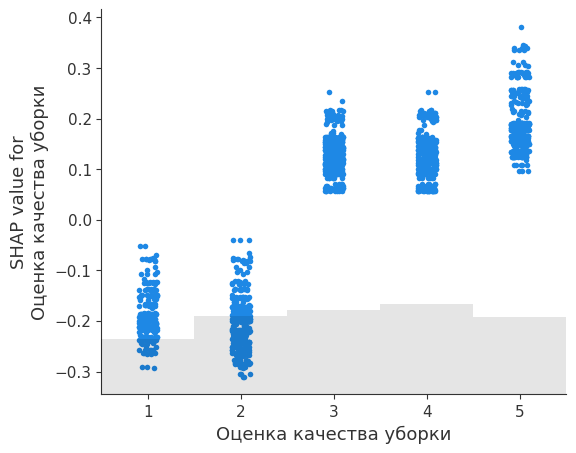

In [ ]:
shap.plots.scatter(shap_val[:,:,1][:,'Оценка качества уборки'])

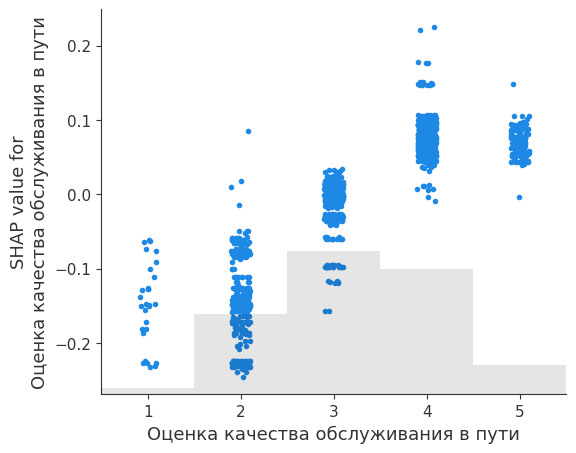

In [ ]:
shap.plots.scatter(shap_val[:,:,1][:,'Оценка качества обслуживания в пути'])

# **График shap.force_plot()**


Для того, чтобы посмотреть на конкретные наблюдения, т.е. получить локальные объяснения, нужно воспользоваться функцией `shap.force_plot()`, передав ей на вход базовое значение и значение Шепли для интересующего нас образца.

Эта диаграмма показывает те же результаты, что и диаграмма `shap.plots.waterfall`, но расположенной на одной оси.

Например, для 61 наблюдения в датасете:

In [ ]:

shap.initjs()

shap.plots.force(shap_val[:,:,1][117])


Полученный график показывает, как разные признаки влияют на итоговое предсказание модели.

* `Base value` (базовое значение) – среднее значение, полученное при обучении;
* Жирным выделено полученное значение;

В случае классификации, какие-то переменные сдвигают его к классу 0, а какие-то к 1. Так, если значение Шепли положительное (выделено розовым цветом), то оно смещает предсказание в сторону положительного класса (1, вправо), если негативное (выделено голубым) - отрицательного (0, влево).

In [ ]:
# Для первых 15 наблюдений тестовой выборки
shap.initjs()

shap.plots.force(shap_val[:,:,1][:15])

In [ ]:
# Для всех наблюдений тестовой выборки
shap.initjs()
shap.force_plot(shap_val[:,:,1])

## Выводы

* Оценка важности признаков разными методами даёт разные результаты. Поэтому старайтесь использовать несколько различных методов для более точной интерпретации.
* Некоторые выводы о работе модели можно сделать только исходя из общего понимания логики той области, в которой вы занимаетесь моделированием.